In [7]:
%pwd

'/'

In [8]:
%cd /content

/content


In [1]:
import os
import sys

# Clone or pull part
repo_url = "https://github.com/fraco03/6D_pose.git"
repo_dir = "/content/6D_pose"   #Modify here for kaggle
branch = "pose_rgbd"

# Clone if missing
if not os.path.exists(repo_dir):
    !git clone -b {branch} {repo_url}
    print(f"Cloned {repo_url} to {repo_dir}")
else:
    %cd {repo_dir}
    !git fetch origin
    !git checkout {branch}
    !git reset --hard origin/{branch}
    # %cd ..
    print(f"Updated {repo_url} to {repo_dir}")

# Add repository to Python path
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)


Cloning into '6D_pose'...
remote: Enumerating objects: 488, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 488 (delta 82), reused 92 (delta 42), pack-reused 334 (from 1)
Receiving objects: 100% (488/488), 6.17 MiB | 14.19 MiB/s, done.
Resolving deltas: 100% (248/248), done.
Cloned https://github.com/fraco03/6D_pose.git to /content/6D_pose


In [2]:
# %cd ..
!gdown --fuzzy https://drive.google.com/file/d/1Zwh-gAk_-CBgpOcNLPLdFNxggi3NTh-S/view?usp=sharing -O Linemod_preprocessed.zip
!unzip Linemod_preprocessed.zip
%cd 6D_pose

Output streaming troncato alle ultime 5000 righe.
  inflating: Linemod_preprocessed/segnet_results/11_label/0207_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0208_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0209_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0210_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0211_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0212_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0213_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0214_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0215_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0216_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0218_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0219_label.png  
  inflating: Linemod_preprocessed/segnet_results/1

In [6]:
%cd ..
%mv Linemod_preprocessed /content

In [ ]:
%pwd

In [ ]:
import sys

sys.path.append('../..')

In [3]:
from google.colab import drive
from utils.load_data import mount_drive

# Mounting part
mount_drive()

Mounted at /content/drive
✅ Drive mounted at /content/drive


In [4]:
# dataset_root = "/content/drive/MyDrive/Linemod_preprocessed" #Modify here for kaggle
# dataset_root = "../../Linemod_preprocessed_small"
dataset_root = "/content/Linemod_preprocessed"

print("\n✅ Setup complete!")
print(f"📁 Dataset path: {dataset_root}")



✅ Setup complete!
📁 Dataset path: /content/Linemod_preprocessed


In [ ]:
%load_ext autoreload
%autoreload 2

In [5]:
!pip install plyfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.3 MB/s eta 0:00:00


In [6]:
from src.pose_rgbd.loss import GeodesicLoss
from src.pose_rgbd.dataset import LineModPoseDepthDataset

train_dataset = LineModPoseDepthDataset(
    root_dir=dataset_root,
    split="train"
)

test_dataset = LineModPoseDepthDataset(
    root_dir=dataset_root,
    split="test"
)


✅ LineModConfig initialized: /content/Linemod_preprocessed
 Loaded LineModPoseDepthDataset
   Split: train
   Objects: [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 3631
 Loaded LineModPoseDepthDataset
   Split: test
   Objects: [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 20528


In [7]:
sample = train_dataset[0]

print(f"Sample keys: {sample.keys()}")
print(f"Depth shape: {sample['depth'].shape}")
print(f"RGB shape: {sample['image'].shape}")

Sample keys: dict_keys(['image', 'depth', 'img_id', 'img_path', 'rotation', 'translation', '3D_center', 'object_id', 'class_idx', 'cam_K', 'bbox'])
Depth shape: torch.Size([1, 224, 224])
RGB shape: torch.Size([3, 224, 224])


In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [9]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import MSELoss
from src.pose_rgbd.model import RotationPredictionModel
from src.pose_rgbd.dataset import LineModPoseDepthDataset
from src.pose_rgbd.loss import GeodesicLoss

# Configurazione del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
model = RotationPredictionModel(pretrained=True, freeze_backbone=True)
model = model.to(device)

# Loss function and optimizer
criterion = GeodesicLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


In [14]:
from tqdm import tqdm
import os
import datetime
from itertools import islice
from datetime import datetime

# Load best model

# Ciclo di training
num_epochs = 50
best_test_loss = float('inf')
# checkpoint_dir = "checkpoints"
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
checkpoint_dir = f'/content/drive/MyDrive/runs/{timestamp}' # modify here for kaggle
os.makedirs(checkpoint_dir, exist_ok=True)
max_validation_batch = 50

# Track losses for plotting
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    train_pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training")
    for batch in train_pbar:
        rgb = batch['image'].to(device)  # RGB image (B, 3, H, W)
        depth = batch['depth'].to(device)  # Depth (B, 1, H, W)
        rotations = batch['rotation'].to(device)  # GT quaternion (B, 4)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(rgb, depth)

        # Calcolo della loss
        loss = criterion(outputs, rotations)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        train_pbar.set_postfix({'loss': epoch_loss / (train_pbar.n + 1)})

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    test_loss = 0.0

    test_pbar = islice(test_loader, max_validation_batch)
    test_pbar = tqdm(test_pbar, desc=f"Epoch [{epoch+1}/{num_epochs}] - Testing")

    with torch.no_grad():
        for batch in test_pbar:
            rgb = batch['image'].to(device)
            depth = batch['depth'].to(device)
            rotations = batch['rotation'].to(device)

            outputs = model(rgb, depth)
            loss = criterion(outputs, rotations)
            test_loss += loss.item()
            test_pbar.set_postfix({'loss': test_loss / (test_pbar.n + 1)})

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {avg_test_loss:.4f}")

    # Save checkpoint if test loss improved
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_loss': avg_test_loss,
        }, checkpoint_path)
        print(f"✅ Checkpoint saved! Best Test Loss: {best_test_loss:.4f}")
    else:
        print(f"⚠️  No improvement. Best Test Loss: {best_test_loss:.4f}")

Epoch [1/50] - Training: 100%|██████████| 114/114 [00:56<00:00,  2.03it/s, loss=0.743]
Epoch [1/50] - Testing: 50it [00:26,  1.90it/s, loss=0.63]


Epoch [1/50], Test Loss: 0.0491
✅ Checkpoint saved! Best Test Loss: 0.0491


Epoch [2/50] - Training: 100%|██████████| 114/114 [00:57<00:00,  1.99it/s, loss=0.667]
Epoch [2/50] - Testing: 50it [00:25,  1.97it/s, loss=0.577]


Epoch [2/50], Test Loss: 0.0449
✅ Checkpoint saved! Best Test Loss: 0.0449


Epoch [3/50] - Training: 100%|██████████| 114/114 [00:57<00:00,  2.00it/s, loss=0.621]
Epoch [3/50] - Testing: 50it [00:23,  2.10it/s, loss=0.577]


Epoch [3/50], Test Loss: 0.0449
✅ Checkpoint saved! Best Test Loss: 0.0449


Epoch [4/50] - Training: 100%|██████████| 114/114 [01:00<00:00,  1.88it/s, loss=0.576]
Epoch [4/50] - Testing: 50it [00:24,  2.08it/s, loss=0.53]


Epoch [4/50], Test Loss: 0.0413
✅ Checkpoint saved! Best Test Loss: 0.0413


Epoch [5/50] - Training: 100%|██████████| 114/114 [00:57<00:00,  1.99it/s, loss=0.532]
Epoch [5/50] - Testing: 50it [00:25,  1.98it/s, loss=0.51]


Epoch [5/50], Test Loss: 0.0397
✅ Checkpoint saved! Best Test Loss: 0.0397


Epoch [6/50] - Training: 100%|██████████| 114/114 [00:56<00:00,  2.01it/s, loss=0.493]
Epoch [6/50] - Testing: 50it [00:25,  1.97it/s, loss=0.511]


Epoch [6/50], Test Loss: 0.0398
⚠️  No improvement. Best Test Loss: 0.0397


Epoch [7/50] - Training: 100%|██████████| 114/114 [00:54<00:00,  2.08it/s, loss=0.468]
Epoch [7/50] - Testing: 50it [00:24,  2.03it/s, loss=0.504]


Epoch [7/50], Test Loss: 0.0393
✅ Checkpoint saved! Best Test Loss: 0.0393


Epoch [8/50] - Training: 100%|██████████| 114/114 [00:56<00:00,  2.01it/s, loss=0.431]
Epoch [8/50] - Testing: 50it [00:25,  1.96it/s, loss=0.503]


Epoch [8/50], Test Loss: 0.0392
✅ Checkpoint saved! Best Test Loss: 0.0392


Epoch [9/50] - Training: 100%|██████████| 114/114 [00:56<00:00,  2.01it/s, loss=0.403]
Epoch [9/50] - Testing: 50it [00:25,  1.98it/s, loss=0.509]


Epoch [9/50], Test Loss: 0.0396
⚠️  No improvement. Best Test Loss: 0.0392


Epoch [10/50] - Training: 100%|██████████| 114/114 [00:55<00:00,  2.05it/s, loss=0.375]
Epoch [10/50] - Testing: 50it [00:23,  2.10it/s, loss=0.488]


Epoch [10/50], Test Loss: 0.0380
✅ Checkpoint saved! Best Test Loss: 0.0380


Epoch [11/50] - Training: 100%|██████████| 114/114 [00:56<00:00,  2.03it/s, loss=0.345]
Epoch [11/50] - Testing: 50it [00:25,  1.99it/s, loss=0.488]


Epoch [11/50], Test Loss: 0.0380
⚠️  No improvement. Best Test Loss: 0.0380


Epoch [12/50] - Training: 100%|██████████| 114/114 [00:55<00:00,  2.05it/s, loss=0.329]
Epoch [12/50] - Testing: 50it [00:24,  2.01it/s, loss=0.481]


Epoch [12/50], Test Loss: 0.0375
✅ Checkpoint saved! Best Test Loss: 0.0375


Epoch [13/50] - Training: 100%|██████████| 114/114 [00:56<00:00,  2.03it/s, loss=0.316]
Epoch [13/50] - Testing: 50it [00:24,  2.06it/s, loss=0.466]


Epoch [13/50], Test Loss: 0.0363
✅ Checkpoint saved! Best Test Loss: 0.0363


Epoch [14/50] - Training: 100%|██████████| 114/114 [00:56<00:00,  2.00it/s, loss=0.302]
Epoch [14/50] - Testing: 50it [00:25,  1.99it/s, loss=0.478]


Epoch [14/50], Test Loss: 0.0373
⚠️  No improvement. Best Test Loss: 0.0363


Epoch [15/50] - Training: 100%|██████████| 114/114 [00:55<00:00,  2.05it/s, loss=0.29]
Epoch [15/50] - Testing: 50it [00:25,  1.98it/s, loss=0.468]


Epoch [15/50], Test Loss: 0.0364
⚠️  No improvement. Best Test Loss: 0.0363


Epoch [16/50] - Training: 100%|██████████| 114/114 [00:54<00:00,  2.10it/s, loss=0.277]
Epoch [16/50] - Testing: 50it [00:24,  2.03it/s, loss=0.495]


Epoch [16/50], Test Loss: 0.0386
⚠️  No improvement. Best Test Loss: 0.0363


Epoch [17/50] - Training: 100%|██████████| 114/114 [00:55<00:00,  2.05it/s, loss=0.265]
Epoch [17/50] - Testing: 50it [00:25,  1.99it/s, loss=0.477]


Epoch [17/50], Test Loss: 0.0371
⚠️  No improvement. Best Test Loss: 0.0363


Epoch [18/50] - Training: 100%|██████████| 114/114 [00:55<00:00,  2.04it/s, loss=0.267]
Epoch [18/50] - Testing: 50it [00:23,  2.10it/s, loss=0.433]


Epoch [18/50], Test Loss: 0.0338
✅ Checkpoint saved! Best Test Loss: 0.0338


Epoch [19/50] - Training: 100%|██████████| 114/114 [00:56<00:00,  2.03it/s, loss=0.269]
Epoch [19/50] - Testing: 50it [00:25,  1.99it/s, loss=0.444]


Epoch [19/50], Test Loss: 0.0346
⚠️  No improvement. Best Test Loss: 0.0338


Epoch [20/50] - Training: 100%|██████████| 114/114 [00:55<00:00,  2.04it/s, loss=0.256]
Epoch [20/50] - Testing: 50it [00:25,  1.98it/s, loss=0.443]


Epoch [20/50], Test Loss: 0.0345
⚠️  No improvement. Best Test Loss: 0.0338


Epoch [21/50] - Training: 100%|██████████| 114/114 [00:55<00:00,  2.06it/s, loss=0.238]
Epoch [21/50] - Testing: 50it [00:23,  2.11it/s, loss=0.439]


Epoch [21/50], Test Loss: 0.0342
⚠️  No improvement. Best Test Loss: 0.0338


Epoch [22/50] - Training: 100%|██████████| 114/114 [00:55<00:00,  2.05it/s, loss=0.226]
Epoch [22/50] - Testing: 50it [00:25,  1.98it/s, loss=0.475]


Epoch [22/50], Test Loss: 0.0370
⚠️  No improvement. Best Test Loss: 0.0338


Epoch [23/50] - Training: 100%|██████████| 114/114 [00:55<00:00,  2.04it/s, loss=0.234]
Epoch [23/50] - Testing: 50it [00:25,  1.98it/s, loss=0.436]


Epoch [23/50], Test Loss: 0.0339
⚠️  No improvement. Best Test Loss: 0.0338


Epoch [24/50] - Training: 100%|██████████| 114/114 [00:54<00:00,  2.09it/s, loss=0.224]
Epoch [24/50] - Testing: 50it [00:24,  2.03it/s, loss=0.427]


Epoch [24/50], Test Loss: 0.0333
✅ Checkpoint saved! Best Test Loss: 0.0333


Epoch [25/50] - Training: 100%|██████████| 114/114 [00:56<00:00,  2.02it/s, loss=0.221]
Epoch [25/50] - Testing: 50it [00:25,  1.98it/s, loss=0.437]


Epoch [25/50], Test Loss: 0.0340
⚠️  No improvement. Best Test Loss: 0.0333


Epoch [26/50] - Training: 100%|██████████| 114/114 [00:55<00:00,  2.04it/s, loss=0.211]
Epoch [26/50] - Testing: 50it [00:24,  2.03it/s, loss=0.43]


Epoch [26/50], Test Loss: 0.0335
⚠️  No improvement. Best Test Loss: 0.0333


Epoch [27/50] - Training: 100%|██████████| 114/114 [00:54<00:00,  2.08it/s, loss=0.217]
Epoch [27/50] - Testing: 50it [00:25,  1.96it/s, loss=0.434]


Epoch [27/50], Test Loss: 0.0338
⚠️  No improvement. Best Test Loss: 0.0333


Epoch [28/50] - Training: 100%|██████████| 114/114 [00:55<00:00,  2.04it/s, loss=0.209]
Epoch [28/50] - Testing: 50it [00:25,  1.99it/s, loss=0.42]


Epoch [28/50], Test Loss: 0.0327
✅ Checkpoint saved! Best Test Loss: 0.0327


Epoch [29/50] - Training: 100%|██████████| 114/114 [00:56<00:00,  2.02it/s, loss=0.196]
Epoch [29/50] - Testing: 50it [00:23,  2.09it/s, loss=0.416]


Epoch [29/50], Test Loss: 0.0324
✅ Checkpoint saved! Best Test Loss: 0.0324


Epoch [30/50] - Training: 100%|██████████| 114/114 [00:56<00:00,  2.02it/s, loss=0.194]
Epoch [30/50] - Testing: 50it [00:25,  1.98it/s, loss=0.405]


Epoch [30/50], Test Loss: 0.0315
✅ Checkpoint saved! Best Test Loss: 0.0315


Epoch [31/50] - Training: 100%|██████████| 114/114 [00:56<00:00,  2.01it/s, loss=0.195]
Epoch [31/50] - Testing: 50it [00:25,  1.97it/s, loss=0.445]


Epoch [31/50], Test Loss: 0.0346
⚠️  No improvement. Best Test Loss: 0.0315


Epoch [32/50] - Training: 100%|██████████| 114/114 [00:56<00:00,  2.02it/s, loss=0.193]
Epoch [32/50] - Testing: 50it [00:23,  2.11it/s, loss=0.407]


Epoch [32/50], Test Loss: 0.0317
⚠️  No improvement. Best Test Loss: 0.0315


Epoch [33/50] - Training: 100%|██████████| 114/114 [00:55<00:00,  2.04it/s, loss=0.191]
Epoch [33/50] - Testing: 50it [00:25,  1.94it/s, loss=0.401]


Epoch [33/50], Test Loss: 0.0312
✅ Checkpoint saved! Best Test Loss: 0.0312


Epoch [34/50] - Training: 100%|██████████| 114/114 [00:56<00:00,  2.01it/s, loss=0.19]
Epoch [34/50] - Testing: 50it [00:27,  1.79it/s, loss=0.409]


Epoch [34/50], Test Loss: 0.0319
⚠️  No improvement. Best Test Loss: 0.0312


Epoch [35/50] - Training: 100%|██████████| 114/114 [01:05<00:00,  1.75it/s, loss=0.181]
Epoch [35/50] - Testing: 50it [00:25,  1.93it/s, loss=0.403]


Epoch [35/50], Test Loss: 0.0314
⚠️  No improvement. Best Test Loss: 0.0312


Epoch [36/50] - Training: 100%|██████████| 114/114 [00:56<00:00,  2.01it/s, loss=0.18]
Epoch [36/50] - Testing: 50it [00:25,  1.96it/s, loss=0.41]


Epoch [36/50], Test Loss: 0.0319
⚠️  No improvement. Best Test Loss: 0.0312


Epoch [37/50] - Training: 100%|██████████| 114/114 [00:56<00:00,  2.01it/s, loss=0.178]
Epoch [37/50] - Testing: 50it [00:25,  1.98it/s, loss=0.394]


Epoch [37/50], Test Loss: 0.0307
✅ Checkpoint saved! Best Test Loss: 0.0307


Epoch [38/50] - Training: 100%|██████████| 114/114 [00:56<00:00,  2.02it/s, loss=0.176]
Epoch [38/50] - Testing: 50it [00:23,  2.11it/s, loss=0.398]


Epoch [38/50], Test Loss: 0.0310
⚠️  No improvement. Best Test Loss: 0.0307


Epoch [39/50] - Training: 100%|██████████| 114/114 [00:55<00:00,  2.04it/s, loss=0.174]
Epoch [39/50] - Testing: 50it [00:25,  1.98it/s, loss=0.391]


Epoch [39/50], Test Loss: 0.0304
✅ Checkpoint saved! Best Test Loss: 0.0304


Epoch [40/50] - Training: 100%|██████████| 114/114 [00:57<00:00,  2.00it/s, loss=0.175]
Epoch [40/50] - Testing: 50it [00:25,  1.94it/s, loss=0.396]


Epoch [40/50], Test Loss: 0.0308
⚠️  No improvement. Best Test Loss: 0.0304


Epoch [41/50] - Training: 100%|██████████| 114/114 [00:55<00:00,  2.06it/s, loss=0.171]
Epoch [41/50] - Testing: 50it [00:24,  2.06it/s, loss=0.379]


Epoch [41/50], Test Loss: 0.0295
✅ Checkpoint saved! Best Test Loss: 0.0295


Epoch [42/50] - Training: 100%|██████████| 114/114 [00:57<00:00,  2.00it/s, loss=0.167]
Epoch [42/50] - Testing: 50it [00:25,  1.96it/s, loss=0.39]


Epoch [42/50], Test Loss: 0.0304
⚠️  No improvement. Best Test Loss: 0.0295


Epoch [43/50] - Training: 100%|██████████| 114/114 [00:56<00:00,  2.03it/s, loss=0.166]
Epoch [43/50] - Testing: 50it [00:25,  1.95it/s, loss=0.396]


Epoch [43/50], Test Loss: 0.0309
⚠️  No improvement. Best Test Loss: 0.0295


Epoch [44/50] - Training: 100%|██████████| 114/114 [00:55<00:00,  2.04it/s, loss=0.164]
Epoch [44/50] - Testing: 50it [00:23,  2.09it/s, loss=0.401]


Epoch [44/50], Test Loss: 0.0313
⚠️  No improvement. Best Test Loss: 0.0295


Epoch [45/50] - Training: 100%|██████████| 114/114 [00:55<00:00,  2.04it/s, loss=0.16]
Epoch [45/50] - Testing: 50it [00:25,  1.98it/s, loss=0.405]


Epoch [45/50], Test Loss: 0.0315
⚠️  No improvement. Best Test Loss: 0.0295


Epoch [46/50] - Training: 100%|██████████| 114/114 [00:55<00:00,  2.04it/s, loss=0.159]
Epoch [46/50] - Testing: 50it [00:24,  2.02it/s, loss=0.407]


Epoch [46/50], Test Loss: 0.0317
⚠️  No improvement. Best Test Loss: 0.0295


Epoch [47/50] - Training: 100%|██████████| 114/114 [00:54<00:00,  2.09it/s, loss=0.166]
Epoch [47/50] - Testing: 50it [00:25,  1.98it/s, loss=0.392]


Epoch [47/50], Test Loss: 0.0305
⚠️  No improvement. Best Test Loss: 0.0295


Epoch [48/50] - Training: 100%|██████████| 114/114 [00:55<00:00,  2.04it/s, loss=0.16]
Epoch [48/50] - Testing: 50it [00:25,  1.97it/s, loss=0.4]


Epoch [48/50], Test Loss: 0.0311
⚠️  No improvement. Best Test Loss: 0.0295


Epoch [49/50] - Training: 100%|██████████| 114/114 [00:55<00:00,  2.06it/s, loss=0.163]
Epoch [49/50] - Testing: 50it [00:24,  2.04it/s, loss=0.406]


Epoch [49/50], Test Loss: 0.0316
⚠️  No improvement. Best Test Loss: 0.0295


Epoch [50/50] - Training: 100%|██████████| 114/114 [00:55<00:00,  2.05it/s, loss=0.158]
Epoch [50/50] - Testing: 50it [00:25,  1.95it/s, loss=0.389]

Epoch [50/50], Test Loss: 0.0303
⚠️  No improvement. Best Test Loss: 0.0295


✅ Plot saved: /content/drive/MyDrive/runs/20251218_182514/loss_comparison.png


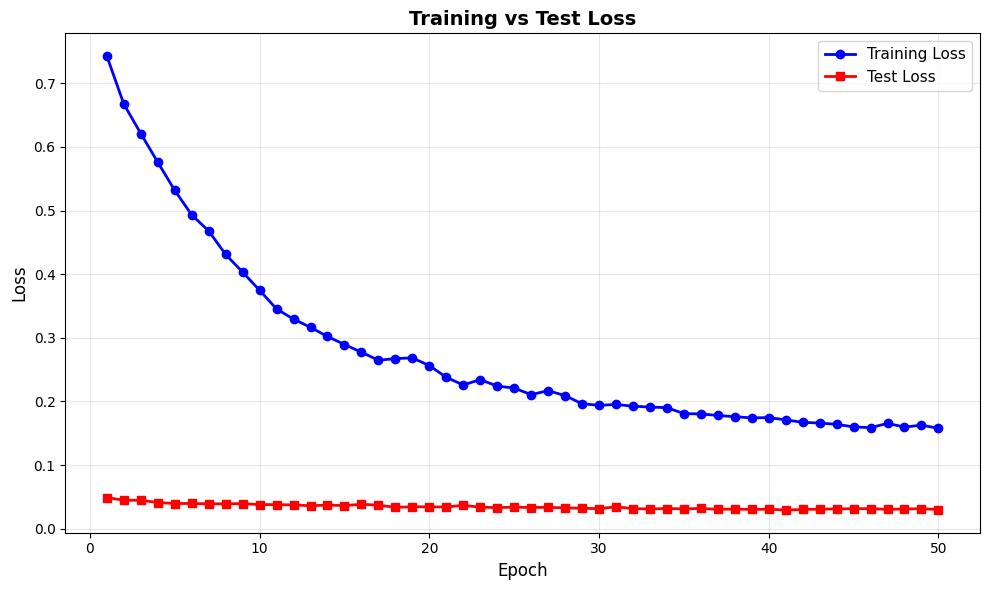

✅ Plot saved: /content/drive/MyDrive/runs/20251218_182514/training_loss.png


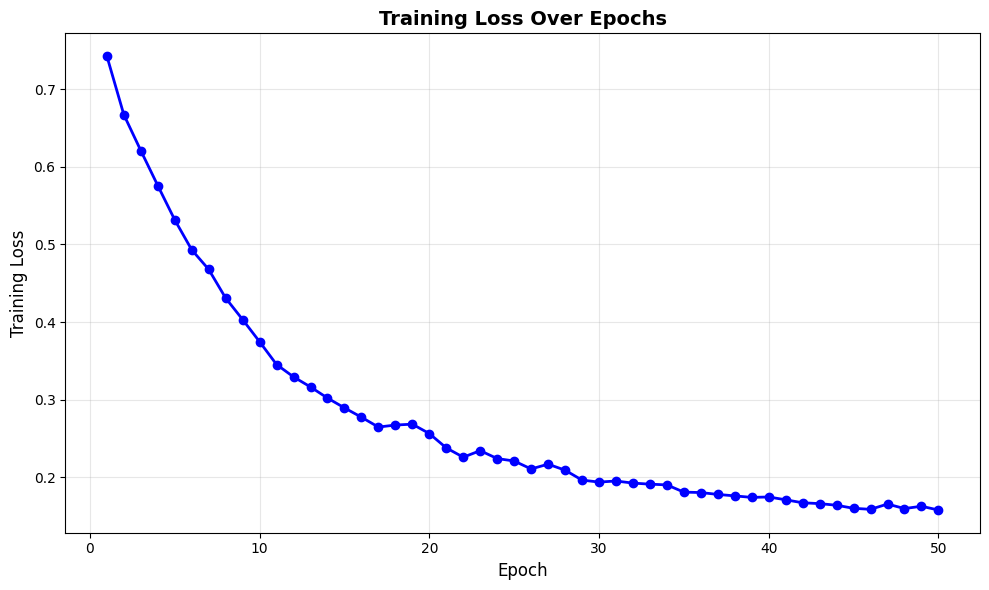

✅ Plot saved: /content/drive/MyDrive/runs/20251218_182514/test_loss.png


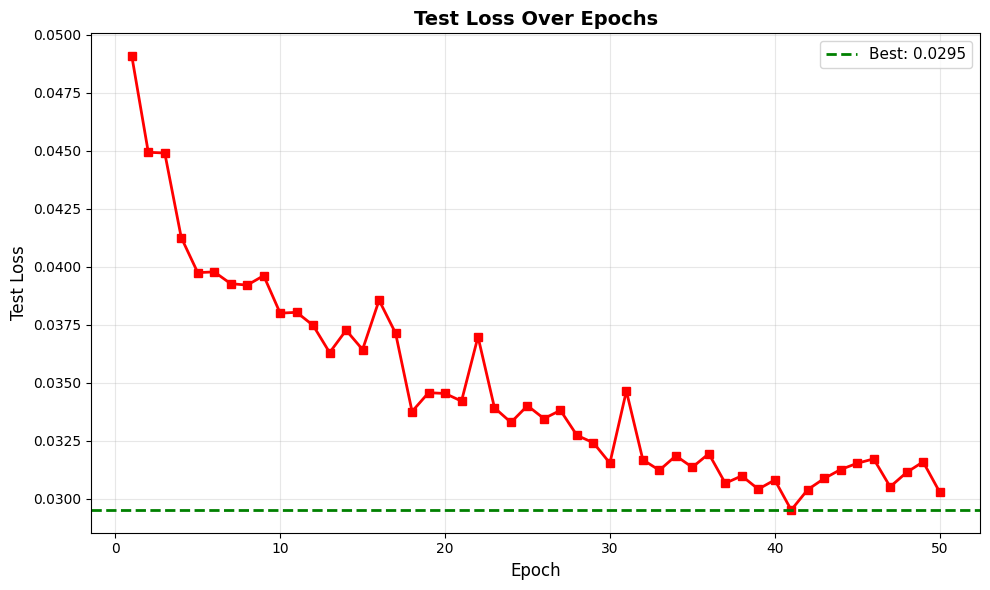


✅ All plots saved in '/content/drive/MyDrive/runs/20251218_182514' directory!


In [15]:
import matplotlib.pyplot as plt

# Create plots directory
# plots_dir = "plots"
plots_dir = checkpoint_dir
os.makedirs(plots_dir, exist_ok=True)

# Plot 1: Training vs Test Loss
plt.figure(figsize=(10, 6))
epochs_range = range(1, num_epochs + 1)
plt.plot(epochs_range, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
plt.plot(epochs_range, test_losses, 'r-s', label='Test Loss', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training vs Test Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
loss_plot_path = os.path.join(plots_dir, "loss_comparison.png")
plt.savefig(loss_plot_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved: {loss_plot_path}")
plt.show()

# Plot 2: Only Training Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, 'b-o', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
train_loss_path = os.path.join(plots_dir, "training_loss.png")
plt.savefig(train_loss_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved: {train_loss_path}")
plt.show()

# Plot 3: Only Test Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, test_losses, 'r-s', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.title('Test Loss Over Epochs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=best_test_loss, color='g', linestyle='--', label=f'Best: {best_test_loss:.4f}', linewidth=2)
plt.legend(fontsize=11)
plt.tight_layout()
test_loss_path = os.path.join(plots_dir, "test_loss.png")
plt.savefig(test_loss_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved: {test_loss_path}")
plt.show()

print(f"\n✅ All plots saved in '{plots_dir}' directory!")

In [18]:
# Save losses
import pickle

test_mod = [t * len(test_dataset) / (50 * 32) for t in test_losses]

losses_dict = {
    'train_losses': train_losses,
    'test_losses': test_mod
}

losses_path = os.path.join(checkpoint_dir, "losses.pkl")
with open(losses_path, 'wb') as f:
    pickle.dump(losses_dict, f)


# Visualize samples

✅ Loaded best model from epoch 41 with test loss: 0.0295

📷 Visualizing sample 944:
   Object ID: 1
   Image ID: 1111

📊 Ground Truth vs Prediction:
   GT Rotation: [-0.06426775 -0.05037272  0.8060376  -0.5862044 ]
   Pred Rotation: [-0.1768444  -0.20898958  0.7444215  -0.60900426]
   GT Translation: [-0.16187614 -0.07858387  0.8682169 ]

✅ Visualization saved!


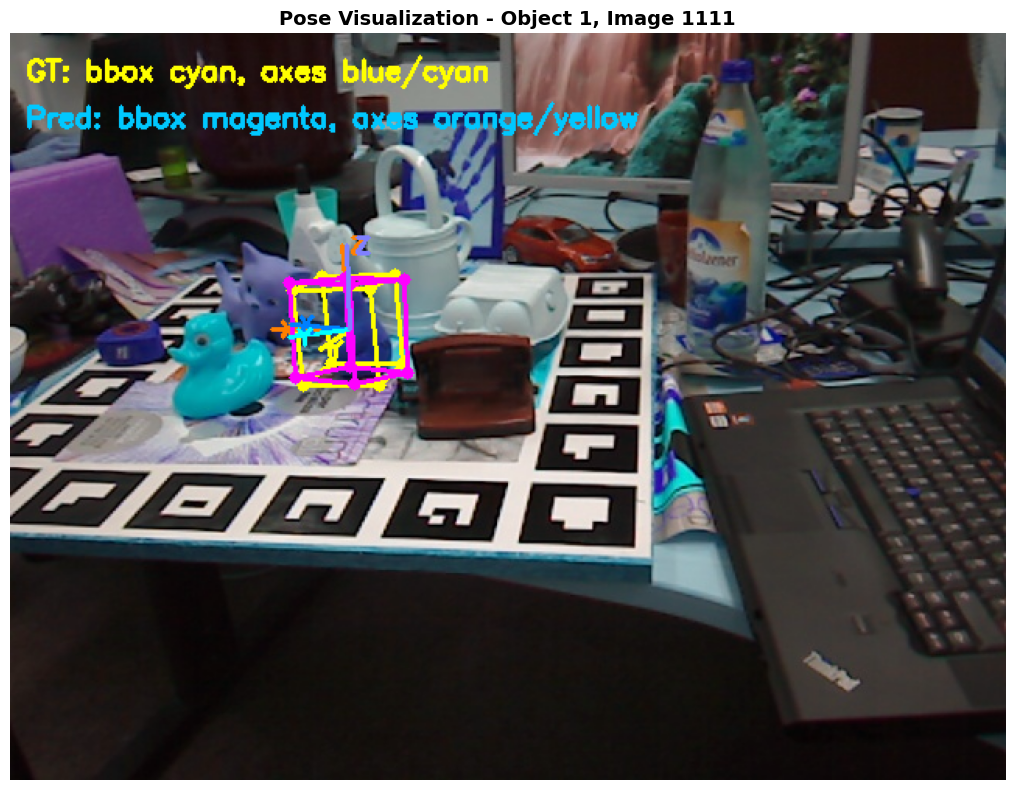

In [30]:
import random
import cv2
from utils.projection_utils import setup_projection_utils, visualize_pose_comparison, get_image

# Setup projection utils
setup_projection_utils(dataset_root)

# Load best model
best_checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")
checkpoint = torch.load(best_checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded best model from epoch {checkpoint['epoch']} with test loss: {checkpoint['test_loss']:.4f}")

# Select a random sample from test dataset
random_idx = random.randint(0, len(test_dataset) - 1)
sample = test_dataset[random_idx]

print(f"\n📷 Visualizing sample {random_idx}:")
print(f"   Object ID: {sample['object_id']}")
print(f"   Image ID: {sample['img_id']}")

# Get the original image
img_path = sample['img_path']
image_rgb = cv2.imread(str(img_path))
image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)

# Prepare input for model
rgb = sample['image'].unsqueeze(0).to(device)  # Add batch dimension
depth = sample['depth'].unsqueeze(0).to(device)  # Add batch and channel dimensions

# Get model prediction
model.eval()
with torch.no_grad():
    pred_rotation = model(rgb, depth)[0].cpu().numpy()

# Get ground truth
gt_rotation = sample['rotation'].numpy()
gt_translation = sample['translation'].numpy()

# Get camera intrinsics
cam_K = sample['cam_K'].numpy()

print(f"\n📊 Ground Truth vs Prediction:")
print(f"   GT Rotation: {gt_rotation}")
print(f"   Pred Rotation: {pred_rotation}")
print(f"   GT Translation: {gt_translation}")

# Visualize pose comparison
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
img_vis = visualize_pose_comparison(
    image_rgb,
    object_id=sample['object_id'],
    cam_K=cam_K,
    gt_rotation=gt_rotation,
    gt_translation=gt_translation,
    pred_rotation=pred_rotation,
    pred_translation=gt_translation  # Using GT translation for now
)

# Convert BGR to RGB for matplotlib
img_vis_rgb = cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB)
ax.imshow(img_vis_rgb)
ax.axis('off')
ax.set_title(f"Pose Visualization - Object {sample['object_id']}, Image {sample['img_id']}", fontsize=14, fontweight='bold')
plt.tight_layout()
# plt.savefig(os.path.join(plots_dir, f"pose_visualization_sample_{random_idx}.png"), dpi=150, bbox_inches='tight')
print(f"\n✅ Visualization saved!")
plt.show()